## 포즈별 프레임 추출 및 이미지화

In [ ]:
import os
import cv2
import numpy as np
from google.colab import drive

# ✅ Google Drive 마운트
drive.mount('/content/drive')

# ✅ 설정
base_path = "/content/drive/MyDrive/yoga"  # 포즈별 폴더가 있는 경로
output_dir = "/content/drive/MyDrive/yoga/output_limited"
os.makedirs(output_dir, exist_ok=True)

pose_list = [
    "부장가사나", "우스트라사나", "아도 무카 스바나사나",
    "나바사나", "할라사나"
]

# ✅ stable_ 영상 경로 모으기
def get_all_stable_video_paths(pose_folder_path):
    video_paths = []
    for root, _, files in os.walk(pose_folder_path):
        for file in files:
            if file.endswith(".mp4") and "stable_" in file:
                video_paths.append(os.path.join(root, file))
    return sorted(video_paths)

# ✅ 메모리 폭발 방지용: 프레임 스트리밍 처리
def concat_stable_videos_with_cap_streaming(pose_name, base_path, output_dir, max_frames=3100, fps=30):
    print(f"\n🎬 Processing pose: {pose_name}")
    pose_folder = os.path.join(base_path, pose_name)
    video_paths = get_all_stable_video_paths(pose_folder)

    # 1. 프레임 수 먼저 계산
    frame_counts = []
    for path in video_paths:
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            frame_counts.append(0)
            continue
        count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_counts.append(count)
        cap.release()

    total_frames = sum(frame_counts)
    print(f"📊 총 프레임 수: {total_frames}")

    if total_frames == 0:
        print("⚠️ 프레임 없음")
        return

    # 2. 각 영상별 추출 프레임 수 계산
    if total_frames > max_frames:
        print(f"⏬ {max_frames}프레임으로 균등 샘플링 중...")
        sampling_plan = [
            (path, int(round(count / total_frames * max_frames)))
            for path, count in zip(video_paths, frame_counts)
        ]
    else:
        sampling_plan = [(path, count) for path, count in zip(video_paths, frame_counts)]

    # 3. 첫 영상에서 해상도 추출
    for path in video_paths:
        cap = cv2.VideoCapture(path)
        ret, frame = cap.read()
        cap.release()
        if ret:
            height, width = frame.shape[:2]
            break
    else:
        print("❌ 유효한 영상 없음")
        return

    save_path = os.path.join(output_dir, f"{pose_name}_clipped.mp4")
    writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # 4. 영상 순회하며 스트리밍 저장
    for path, extract_count in sampling_plan:
        cap = cv2.VideoCapture(path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if not cap.isOpened() or total == 0 or extract_count == 0:
            cap.release()
            continue

        if extract_count >= total:
            # 전체 프레임 사용
            for _ in range(total):
                ret, frame = cap.read()
                if not ret:
                    break
                writer.write(frame)
        else:
            # 균등 인덱스로 샘플링
            indices = np.linspace(0, total - 1, extract_count).astype(int)
            current_index = 0
            target_frame = indices[current_index]
            frame_pos = 0

            while cap.isOpened() and current_index < len(indices):
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_pos == target_frame:
                    writer.write(frame)
                    current_index += 1
                    if current_index < len(indices):
                        target_frame = indices[current_index]
                frame_pos += 1

        cap.release()

    writer.release()
    print(f"✅ 저장 완료: {save_path}")

# ✅ 전체 포즈 반복 처리
for pose in pose_list:
    concat_stable_videos_with_cap_streaming(pose, base_path, output_dir, max_frames=3100)


In [ ]:
import cv2
import os

# 영상들이 저장된 폴더 경로
video_folder = '/content/drive/MyDrive/yoga/output_limited'

# 영상 파일 이름 리스트 (영상 이름에 해당하는 리스트)
video_files = [
    '할라사나_clipped.mp4'
]

# 저장할 폴더 경로
output_base_folder = '/content/drive/MyDrive/yoga'

# 영상 파일 순회
for video_file in video_files:
    # 영상 파일 경로 설정
    video_path = os.path.join(video_folder, video_file)

    # 폴더 이름 생성: 영상 이름의 _ 이전 부분에 frames를 추가
    folder_name = video_file.split('_')[0] + '_frames'
    output_folder = os.path.join(output_base_folder, folder_name)

    # 새 폴더 생성
    os.makedirs(output_folder, exist_ok=True)

    # 영상 열기
    cap = cv2.VideoCapture(video_path)

    # 프레임 번호 초기화
    frame_count = 0

    # 프레임 순차적으로 읽어서 저장
    while True:
        ret, frame = cap.read()  # 영상에서 프레임을 읽어옴
        if not ret:
            break  # 더 이상 프레임이 없으면 종료

        # 프레임 파일 이름 지정 (예: frame_0000.jpg, frame_0001.jpg)
        frame_filename = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')

        # 프레임 저장
        cv2.imwrite(frame_filename, frame)

        frame_count += 1

    # 영상 파일 닫기
    cap.release()

    print(f"{video_file}에서 총 {frame_count}개의 프레임을 {folder_name} 폴더에 저장했습니다.")


할라사나_clipped.mp4에서 총 3103개의 프레임을 할라사나_frames 폴더에 저장했습니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필요 시, 영상 자르기

In [ ]:

import cv2
import os

def time_to_frame(time_str, fps):
    h, m, s = map(float, time_str.split(":"))
    return int((h * 3600 + m * 60 + s) * fps)

def cut_video_by_time(video_path, start_time, end_time="end", output_path=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ 영상 열기 실패:", video_path)
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    start_frame = time_to_frame(start_time, fps)

    if end_time == "end":
        end_frame = total_frames - 1
    else:
        end_frame = time_to_frame(end_time, fps)

    if start_frame >= total_frames or end_frame > total_frames:
        print("⚠️ 지정 시간 범위가 영상 길이를 초과합니다.")
        cap.release()
        return

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    if output_path is None:
        base = os.path.splitext(video_path)[0]
        end_str = "end" if end_time == "end" else end_time.replace(":", "-")
        output_path = f"{base}_cut_{start_time.replace(':', '-')}_{end_str}.mp4"

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    cap.release()
    out.release()
    print(f"✅ 잘라낸 영상 저장 완료: {output_path}")

# 03.10
# 04.00

# 10.90
# 11.20
# ✅ 실행
cut_video_by_time(
    video_path="/content/drive/MyDrive/yoga/부장가사나/고급/actorY090/20220729_16.34.52_가산B/camera2/color/요가-가산-B--부장가사나-고급-actorY090-20220729_16.34.52_CAM_2_cut.mp4",
    start_time="00:00:08.00",
    end_time="00:00:11.00"
)

✅ 잘라낸 영상 저장 완료: /content/drive/MyDrive/yoga/부장가사나/고급/actorY090/20220729_16.34.52_가산B/camera2/color/요가-가산-B--부장가사나-고급-actorY090-20220729_16.34.52_CAM_2_cut_cut_00-00-08.00_00-00-11.00.mp4


## 포즈별 이미지  개수 맞추기

In [ ]:

from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 루트 디렉토리 설정
root_dir = '/content/drive/MyDrive/yoga'

# 결과 저장할 딕셔너리
file_counts = {}

# 루트 디렉토리 내에서 '_frames'로 끝나는 폴더만 탐색
for name in os.listdir(root_dir):
    path = os.path.join(root_dir, name)
    if os.path.isdir(path) and name.endswith('할라사나_frames'):
        # 이미지 파일만 필터링 (확장자 기준)
        image_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        file_counts[name] = len(image_files)

# 결과 출력
for k, v in file_counts.items():
    print(f"{k}: {v} images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 루트 디렉토리 설정
root_dir = '/content/drive/MyDrive/yoga'
target_count = 1800  # 맞출 이미지 수

# '_frames'로 끝나는 폴더만 대상으로 작업
for name in os.listdir(root_dir):
    path = os.path.join(root_dir, name)
    if os.path.isdir(path) and name.endswith('_frames'):
        # 이미지 파일 목록 가져오기
        image_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_count = len(image_files)

        # 1800장보다 많으면 무작위 삭제
        if image_count > target_count:
            to_delete = image_count - target_count
            print(f"{name}: {image_count} images → Deleting {to_delete} images...")

            # 삭제할 이미지 무작위 선택
            delete_files = random.sample(image_files, to_delete)
            for file in delete_files:
                os.remove(os.path.join(path, file))
            print(f"{name}: ✅ Reduced to {target_count} images")

        else:
            print(f"{name}: {image_count} images — no need to delete ✅")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
비라바드라사나2_frames: 2043 images → Deleting 243 images...
비라바드라사나2_frames: ✅ Reduced to 1800 images
비라바드라사나1_frames: 2091 images → Deleting 291 images...
비라바드라사나1_frames: ✅ Reduced to 1800 images
할라사나_frames: 3038 images → Deleting 1238 images...
할라사나_frames: ✅ Reduced to 1800 images
부장가사나_frames: 1795 images — no need to delete ✅
우스트라사나_frames: 2670 images → Deleting 870 images...
우스트라사나_frames: ✅ Reduced to 1800 images
아도 무카 스바나사나_frames: 3077 images → Deleting 1277 images...
아도 무카 스바나사나_frames: ✅ Reduced to 1800 images
나바사나_frames: 2066 images → Deleting 266 images...
나바사나_frames: ✅ Reduced to 1800 images


## 각 포즈 이미지별 point 추출

In [ ]:
!pip uninstall -y mediapipe numpy
!pip install --no-cache-dir numpy==1.24.3
!pip install --no-cache-dir mediapipe==0.10.14

Found existing installation: mediapipe 0.10.9
Uninstalling mediapipe-0.10.9:
  Successfully uninstalled mediapipe-0.10.9
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 221.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 140.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 185.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 152.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
grpc

In [ ]:
import os
import cv2
import csv
import mediapipe as mp

# 경로 설정
image_dir = '/content/drive/MyDrive/yoga/할라사나_frames'
output_csv = '/content/drive/MyDrive/yoga/keypoints_할라사나.csv'

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# 이미지 파일 리스트
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))])

# CSV 저장용 데이터
keypoints_data = []

# 삭제 카운트
deleted_count = 0
saved_count = 0

for filename in image_files:
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Cannot read image: {filename}")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        row = [filename]
        for lm in results.pose_landmarks.landmark:
            row.extend([lm.x, lm.y, lm.visibility])
        keypoints_data.append(row)
        saved_count += 1
    else:
        print(f"❌ Keypoints not detected in {filename} — deleting")
        os.remove(image_path)
        deleted_count += 1

# CSV 저장
header = ['filename']
for i in range(33):
    header.extend([f'x{i}', f'y{i}', f'v{i}'])

with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(keypoints_data)

print(f"\n✅ CSV 저장 완료: {saved_count}장 저장됨")
print(f"🗑️  삭제된 이미지 수: {deleted_count}장")


/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



✅ CSV 저장 완료: 1749장 저장됨
🗑️  삭제된 이미지 수: 0장


In [ ]:
import os
import random

# 이미지 폴더 경로
image_dir = '/content/drive/MyDrive/yoga/할라사나_frames'

# 이미지 파일 목록
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))])

# 삭제할 개수
delete_count = 100

# 무작위로 삭제할 파일 선택
to_delete = random.sample(image_files, delete_count)

# 삭제 실행
for filename in to_delete:
    os.remove(os.path.join(image_dir, filename))

print(f"✅ 무작위로 {delete_count}장의 이미지 삭제 완료")


✅ 무작위로 100장의 이미지 삭제 완료


In [ ]:
import cv2
import mediapipe as mp
import os
import csv

# 이미지가 있는 폴더 경로
image_folder = '/content/drive/MyDrive/yoga/할라사나_frames'
output_csv = '/content/drive/MyDrive/yoga/keypoints_할라사나.csv'

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# 결과 저장용 리스트
keypoints_data = []

# 이미지 리스트 정렬
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))])

for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = pose.process(image_rgb)

    if results.pose_landmarks:
        row = [filename]
        for lm in results.pose_landmarks.landmark:
            row.extend([lm.x, lm.y, lm.visibility])
        keypoints_data.append(row)
    else:
        print(f"❌ Keypoints not detected in {filename}")

# CSV 저장
header = ['filename']
for i in range(33):
    header.extend([f'x{i}', f'y{i}', f'v{i}'])

with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(keypoints_data)

print(f"✅ Keypoints saved to {output_csv}")


/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


❌ Keypoints not detected in frame_0059.jpg
❌ Keypoints not detected in frame_0060.jpg
❌ Keypoints not detected in frame_0061.jpg
❌ Keypoints not detected in frame_0063.jpg
❌ Keypoints not detected in frame_0064.jpg
❌ Keypoints not detected in frame_0065.jpg
❌ Keypoints not detected in frame_0066.jpg
❌ Keypoints not detected in frame_0067.jpg
❌ Keypoints not detected in frame_0068.jpg
❌ Keypoints not detected in frame_0070.jpg
❌ Keypoints not detected in frame_0072.jpg
❌ Keypoints not detected in frame_0073.jpg
❌ Keypoints not detected in frame_0074.jpg
❌ Keypoints not detected in frame_0075.jpg
❌ Keypoints not detected in frame_0076.jpg
❌ Keypoints not detected in frame_0077.jpg
❌ Keypoints not detected in frame_0079.jpg
❌ Keypoints not detected in frame_0081.jpg
❌ Keypoints not detected in frame_0084.jpg
❌ Keypoints not detected in frame_0119.jpg
❌ Keypoints not detected in frame_0121.jpg
❌ Keypoints not detected in frame_0124.jpg
❌ Keypoints not detected in frame_0126.jpg
❌ Keypoints

## 학습 데이터 확인

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/yoga/training/keypoints_할라사나.csv')

In [ ]:
df.describe()

,x0,y0,v0,x1,y1,v1,x2,y2,v2,x3,...,v29,x30,y30,v30,x31,y31,v31,x32,y32,v32
count,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,...,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000
mean,0.358240,0.669783,0.997420,0.352460,0.673991,0.997299,0.352065,0.674447,0.997320,0.351646,...,0.251477,0.258973,0.674556,0.928910,0.260917,0.709275,0.292544,0.259889,0.717758,0.950989
std,0.059823,0.039833,0.006415,0.060722,0.039984,0.005244,0.060629,0.039837,0.006167,0.060503,...,0.117011,0.077079,0.049166,0.036022,0.074591,0.045423,0.098545,0.074385,0.045046,0.039599
min,0.264802,0.537331,0.880745,0.258232,0.541684,0.910021,0.258053,0.542655,0.877746,0.257859,...,0.084328,0.143175,0.503409,0.614857,0.150961,0.540917,0.036214,0.149543,0.541746,0.467692
25%,0.301009,0.639703,0.997422,0.294089,0.643552,0.997020,0.293703,0.644133,0.997185,0.293192,...,0.172821,0.183289,0.637832,0.915736,0.186601,0.678067,0.230588,0.188250,0.686212,0.945590
50%,0.370931,0.648720,0.998756,0.363129,0.652292,0.998521,0.362732,0.652968,0.998637,0.362536,...,0.211752,0.264536,0.651444,0.934129,0.272085,0.686924,0.271338,0.267510,0.700064,0.956899
75%,0.418632,0.722177,0.999382,0.413929,0.726238,0.999280,0.413251,0.726810,0.999332,0.412575,...,0.295632,0.332140,0.728710,0.950662,0.330777,0.753268,0.328227,0.328588,0.761407,0.966763
max,0.499250,0.743569,0.999997,0.501032,0.749153,0.999997,0.501786,0.749081,0.999995,0.502540,...,0.926486,0.470620,0.764738,0.989842,0.452953,0.785319,0.945704,0.477724,0.800022,0.992938


In [ ]:
df.head(10)

,filename,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v29,x30,y30,v30,x31,y31,v31,x32,y32,v32
0,frame_0000.jpg,0.295256,0.642118,0.999543,0.287942,0.645189,0.999494,0.287494,0.645837,0.999526,...,0.215431,0.192508,0.627801,0.924580,0.198127,0.668997,0.289817,0.193344,0.677439,0.953135
1,frame_0001.jpg,0.296814,0.640932,0.999400,0.289411,0.644145,0.999126,0.289033,0.644526,0.999287,...,0.235783,0.192704,0.629053,0.957157,0.200299,0.670912,0.300058,0.195447,0.677662,0.970347
2,frame_0002.jpg,0.295625,0.640021,0.999813,0.288099,0.642797,0.999773,0.287606,0.643144,0.999815,...,0.195014,0.194868,0.632552,0.960244,0.202715,0.671695,0.296814,0.194328,0.680385,0.976460
3,frame_0003.jpg,0.295331,0.639339,0.999803,0.287811,0.642254,0.999757,0.287401,0.642560,0.999791,...,0.186085,0.195715,0.632072,0.963685,0.202261,0.669625,0.256693,0.194058,0.680856,0.977648
4,frame_0004.jpg,0.297514,0.637711,0.999813,0.290136,0.640712,0.999778,0.289608,0.641317,0.999809,...,0.153134,0.196934,0.633838,0.971976,0.208732,0.671914,0.248208,0.193099,0.680100,0.981383
5,frame_0005.jpg,0.296545,0.637348,0.999834,0.289300,0.640242,0.999819,0.288783,0.640734,0.999836,...,0.178878,0.196743,0.633403,0.962465,0.208896,0.677419,0.285171,0.195520,0.680100,0.977073
6,frame_0006.jpg,0.296003,0.638214,0.999853,0.288934,0.641351,0.999837,0.288560,0.641937,0.999863,...,0.138971,0.197652,0.633445,0.967609,0.208127,0.668281,0.231425,0.193292,0.680788,0.979514
7,frame_0007.jpg,0.295777,0.637274,0.999874,0.288628,0.640150,0.999864,0.288064,0.640582,0.999873,...,0.152305,0.197450,0.633318,0.952792,0.208114,0.671458,0.264753,0.194553,0.681167,0.972391
8,frame_0008.jpg,0.296177,0.638442,0.999844,0.288612,0.640881,0.999815,0.288160,0.641257,0.999844,...,0.158748,0.196783,0.633475,0.967496,0.217882,0.661789,0.257294,0.192693,0.679382,0.980089
9,frame_0009.jpg,0.295916,0.637690,0.999900,0.288770,0.640314,0.999900,0.288236,0.640675,0.999907,...,0.186842,0.195509,0.632936,0.943317,0.212234,0.675089,0.307384,0.196117,0.679914,0.967546


In [ ]:
len(df)

1849

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/yoga/keypoints_우스트라사나.csv')

In [ ]:
len(df2)

1679

In [ ]:
df2.isna().sum()

,0
filename,0
x0,0
y0,0
v0,0
x1,0
...,...
y31,0
v31,0
x32,0
y32,0


In [ ]:
os.listdir('/content/drive/MyDrive/yoga/training')


['비라바드라사나2_frames',
 '비라바드라사나1_frames',
 '부장가사나_frames',
 '우스트라사나_frames',
 '아도 무카 스바나사나_frames',
 '나바사나_frames',
 'keypoints_부장가사나.csv',
 'keypoints_나바사나.csv',
 'keypoints_비라바드라사나1.csv',
 'keypoints_비라바드라사나2.csv',
 'keypoints_아도 무카 스바나사나.csv',
 'keypoints_우스트라사나.csv',
 '할라사나_frames',
 'keypoints_할라사나.csv']

In [ ]:
import os
import pandas as pd

# 분석할 요가 자세 리스트
pose_names = [
    '할라사나',
    '부장가사나',
    '우스트라사나',
    '비라바드라사나1',
    '비라바드라사나2',
    '아도 무카 스바나사나',
    '나바사나'
]

# 기본 경로
base_path = '/content/drive/MyDrive/yoga/training'

# 반복 처리
for pose in pose_names:
    csv_path = os.path.join(base_path, f'keypoints_{pose}.csv')

    if not os.path.exists(csv_path):
        print(f"⚠️ 파일 없음: {csv_path}")
        continue

    print(f"\n🔍 분석 중: {pose}")
    df = pd.read_csv(csv_path)

    # 1. 샘플 수
    print(f" - 샘플 수: {len(df)}")

    # 2. 결측치 개수
    missing = df.isnull().sum().sum()
    print(f" - 전체 결측치 개수: {missing}")

    # 3. visibility < 0.5 비율
    visibility_cols = [col for col in df.columns if col.startswith('v')]
    low_vis_ratio = (df[visibility_cols] < 0.5).sum().sum() / (len(df) * 33)
    print(f" - 낮은 visibility 비율: {low_vis_ratio:.2%}")

    # 4. 좌표 통계 요약
    x_cols = [col for col in df.columns if col.startswith('x')]
    y_cols = [col for col in df.columns if col.startswith('y')]
    print(" - x좌표 평균 범위:", df[x_cols].mean().min(), "~", df[x_cols].mean().max())
    print(" - y좌표 평균 범위:", df[y_cols].mean().min(), "~", df[y_cols].mean().max())



🔍 분석 중: 할라사나
 - 샘플 수: 1749
 - 전체 결측치 개수: 0
 - 낮은 visibility 비율: 26.60%
 - x좌표 평균 범위: 0.25918461670358905 ~ 0.4910972462919114
 - y좌표 평균 범위: 0.5879246916445138 ~ 0.7177831255892061

🔍 분석 중: 부장가사나
 - 샘플 수: 1738
 - 전체 결측치 개수: 0
 - 낮은 visibility 비율: 13.15%
 - x좌표 평균 범위: 0.4217863342412871 ~ 0.5174486837226585
 - y좌표 평균 범위: 0.5113192162421822 ~ 0.6802325326910776

🔍 분석 중: 우스트라사나
 - 샘플 수: 1679
 - 전체 결측치 개수: 0
 - 낮은 visibility 비율: 24.52%
 - x좌표 평균 범위: 0.44261400839130816 ~ 0.4582646821424179
 - y좌표 평균 범위: 0.5009440649578158 ~ 0.6825127916864301

🔍 분석 중: 비라바드라사나1
 - 샘플 수: 1639
 - 전체 결측치 개수: 0
 - 낮은 visibility 비율: 9.21%
 - x좌표 평균 범위: 0.35210722250337734 ~ 0.45880973471818426
 - y좌표 평균 범위: 0.4578354775978342 ~ 0.621237036002126

🔍 분석 중: 비라바드라사나2
 - 샘플 수: 1744
 - 전체 결측치 개수: 0
 - 낮은 visibility 비율: 0.21%
 - x좌표 평균 범위: 0.40648507393486455 ~ 0.5592810947174599
 - y좌표 평균 범위: 0.40354593125505184 ~ 0.6465919487383387

🔍 분석 중: 아도 무카 스바나사나
 - 샘플 수: 1773
 - 전체 결측치 개수: 0
 - 낮은 visibility 비율: 7.34%
 - x좌표 평

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)



In [ ]:
!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

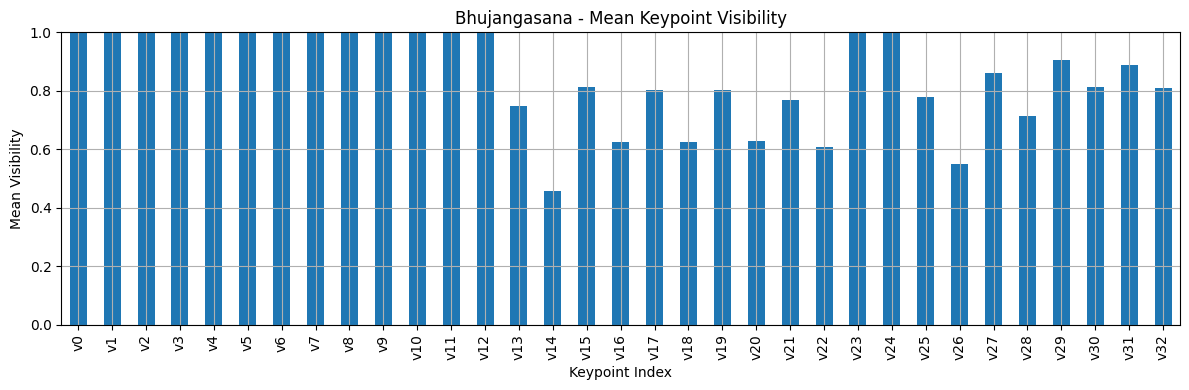

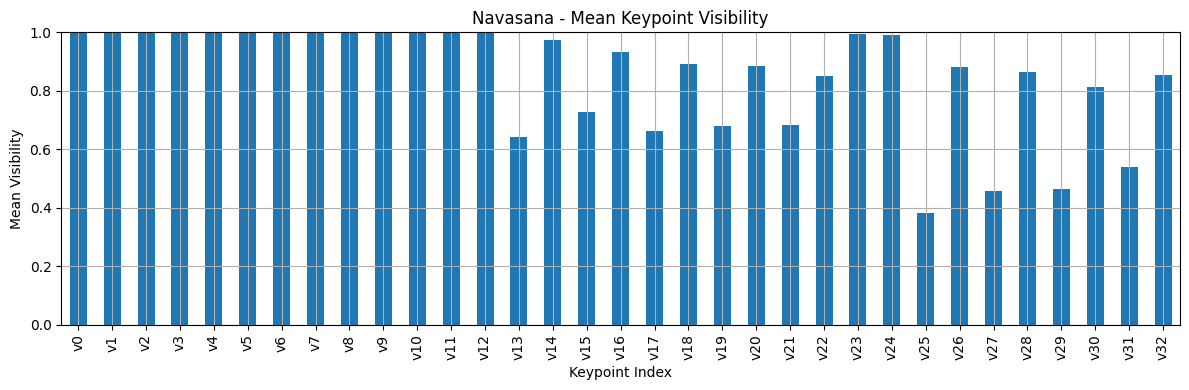

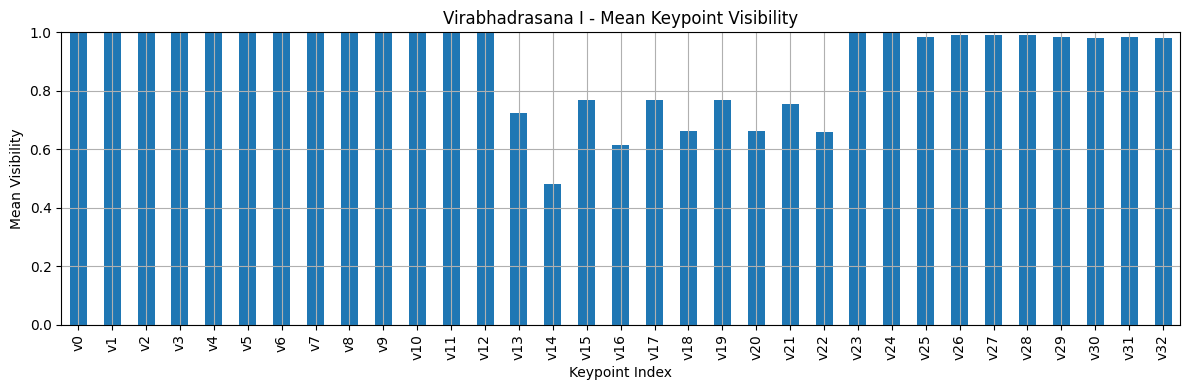

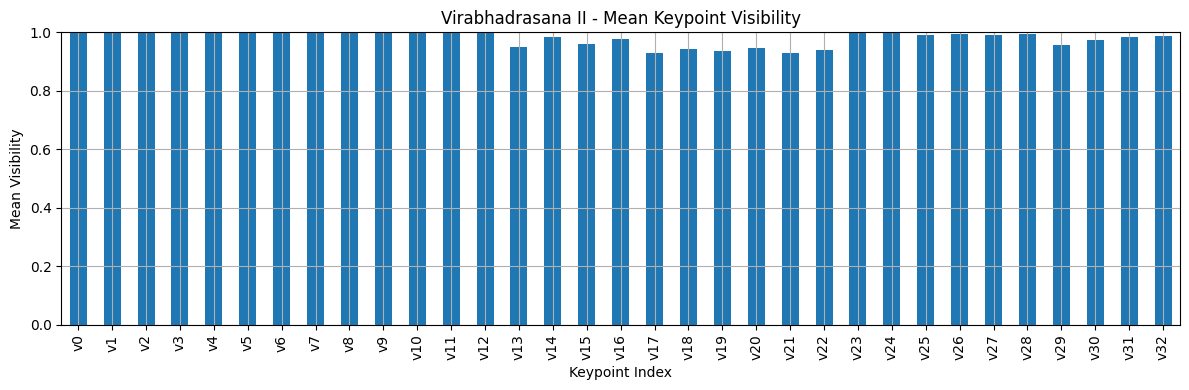

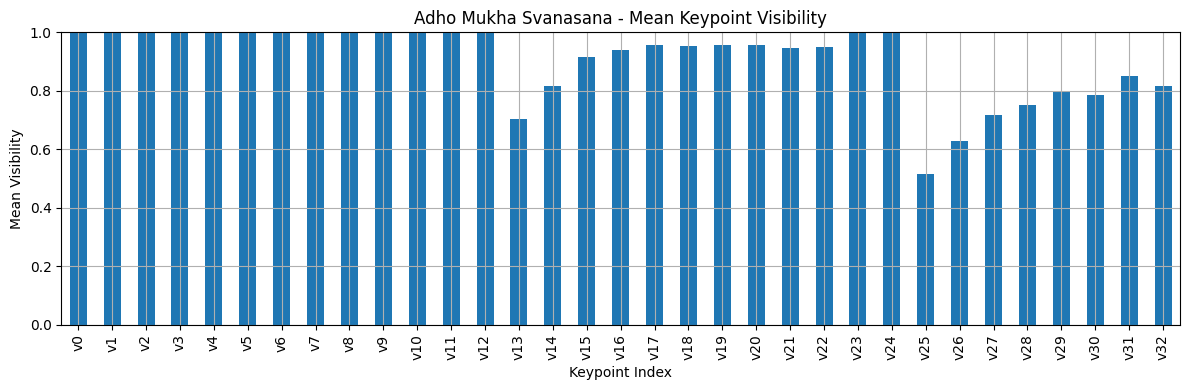

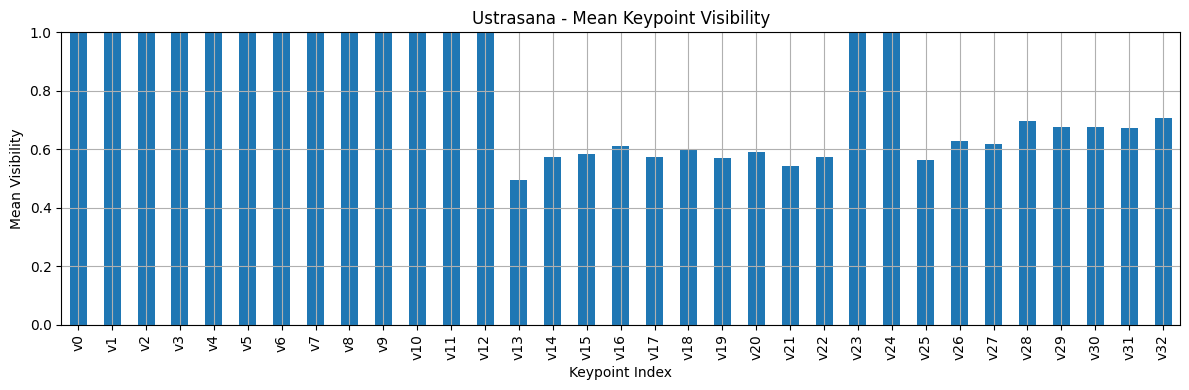

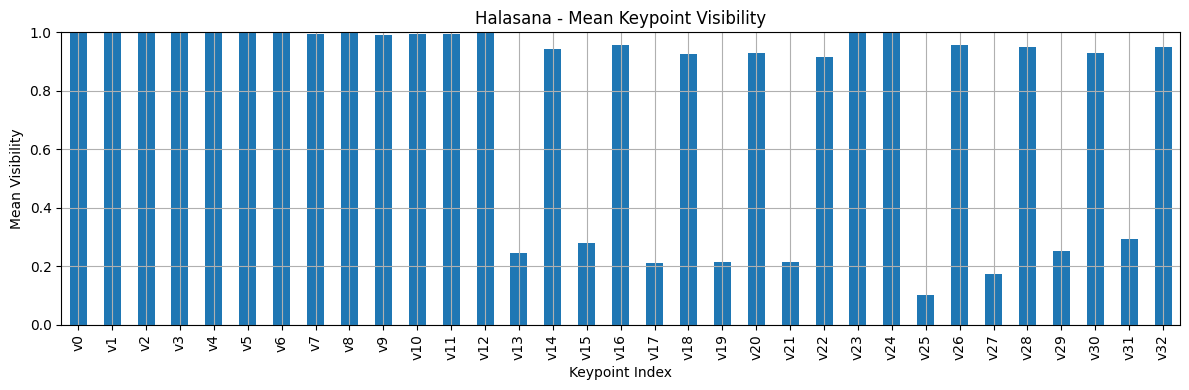

In [ ]:
# ✅ 2. 기본 설정
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import unicodedata

# 경고 제거
warnings.filterwarnings("ignore")


# ✅ 3. 기본 경로 설정
base_path = '/content/drive/MyDrive/yoga/training'

# ✅ 4. CSV 파일 목록에서 포즈명 추출
csv_files = [f for f in os.listdir(base_path) if f.startswith('keypoints_') and f.endswith('.csv')]
pose_names_from_files = [f.replace('keypoints_', '').replace('.csv', '') for f in csv_files]

# ✅ 5. 한글 → 영어 포즈명 매핑
pose_name_map = {
    '할라사나': 'Halasana',
    '부장가사나': 'Bhujangasana',
    '우스트라사나': 'Ustrasana',
    '비라바드라사나1': 'Virabhadrasana I',
    '비라바드라사나2': 'Virabhadrasana II',
    '아도 무카 스바나사나': 'Adho Mukha Svanasana',
    '나바사나': 'Navasana'
}

# ✅ 6. 평균 visibility 계산 및 시각화
visibility_stats = {}

for filename, pose in zip(csv_files, pose_names_from_files):
    csv_path = os.path.join(base_path, filename)
    df = pd.read_csv(csv_path)

    # 🔧 유니코드 정규화 (한글 깨짐 방지)
    pose_normalized = unicodedata.normalize('NFC', pose)
    eng_pose = pose_name_map.get(pose_normalized, pose_normalized)

    # 평균 visibility 계산
    vis_cols = [f'v{i}' for i in range(33)]
    avg_vis = df[vis_cols].mean()
    visibility_stats[pose_normalized] = avg_vis

    # 시각화
    plt.figure(figsize=(12, 4))
    avg_vis.plot(kind='bar', title=f'{eng_pose} - Mean Keypoint Visibility', ylim=(0, 1))
    plt.xlabel('Keypoint Index')
    plt.ylabel('Mean Visibility')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
import pandas as pd

# 🔧 경로 설정
csv_path = '/content/drive/MyDrive/yoga/training/keypoints_할라사나.csv'
image_dir = '/content/drive/MyDrive/yoga/training/할라사나_frames'
output_video_path = '/content/drive/MyDrive/yoga/training/할라사나_keypoints.mp4'

# 🔧 중요 keypoint만 (예: 어깨, 팔꿈치, 손목, 엉덩이, 무릎, 발목)
important_kpts = [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

# CSV 불러오기
df = pd.read_csv(csv_path)

# 프레임 크기 설정
sample_img_path = os.path.join(image_dir, df['filename'].iloc[0])
sample_img = cv2.imread(sample_img_path)
height, width, _ = sample_img.shape

# 영상 저장 준비
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 15
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# 🔁 이미지 반복
for idx, row in df.iterrows():
    image_path = os.path.join(image_dir, row['filename'])
    image = cv2.imread(image_path)
    if image is None:
        continue

    for i in important_kpts:
        x = int(row[f'x{i}'] * width)
        y = int(row[f'y{i}'] * height)
        v = row[f'v{i}']
        if v >= 0.5:
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
            cv2.putText(image, str(i), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    out.write(image)

out.release()
print("✅ 영상 저장 완료:", output_video_path)


✅ 영상 저장 완료: /content/drive/MyDrive/yoga/training/할라사나_keypoints.mp4


## 7개의 Pose 통합 벡터 만들기

### 각 클래스별 라벨
label_to_name = {
    0: 'Halasana',
    1: 'Bhujangasana',
    2: 'Ustrasana',
    3: 'Virabhadrasana I',
    4: 'Virabhadrasana II',
    5: 'Adho Mukha Svanasana',
    6: 'Navasana'
}


### 이미지 사용을 위한 자세별 이미지 이름과 첫번째 열 바꾸기

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def run_full_pipeline_auto(pose_list, base_path, visibility_threshold=0.5, mask_value=-1.0):
    """
    [Auto 시점 판단 기반] 전체 자세 리스트를 처리하여
    정규화 + 마스킹 + 시점 정렬 + 라벨링 완료된 X, y, label map 반환
    """

    def normalize_pose_by_view_auto(df, visibility_threshold=0.5):
        left_right_pairs = [
            (11, 12), (13, 14), (15, 16),
            (23, 24), (25, 26), (27, 28),
            (1, 4), (2, 5), (3, 6), (7, 8),
            (30, 32), (31, 29), (22, 21), (20, 19), (18, 17)
        ]
        df = df.copy()
        if 'x11' not in df.columns or 'x12' not in df.columns:
            return df
        v11 = df['v11']
        v12 = df['v12']
        valid = (v11 >= visibility_threshold) & (v12 >= visibility_threshold)
        if valid.sum() == 0:
            return df
        x11_mean = df.loc[valid, 'x11'].mean()
        x12_mean = df.loc[valid, 'x12'].mean()
        if x12_mean < x11_mean:
            for left, right in left_right_pairs:
                for axis in ['x', 'y', 'v']:
                    l_col, r_col = f'{axis}{left}', f'{axis}{right}'
                    df[l_col], df[r_col] = df[r_col], df[l_col]
        return df

    def preprocess_with_auto_pipeline(csv_path, visibility_threshold=0.5, mask_value=-1.0):
        df = pd.read_csv(csv_path)
        df = normalize_pose_by_view_auto(df, visibility_threshold=visibility_threshold)
        vectors = []
        for _, row in df.iterrows():
            vector = []
            v11, v12 = row['v11'], row['v12']
            x11, x12 = row['x11'], row['x12']
            y11, y12 = row['y11'], row['y12']
            if v11 >= visibility_threshold and v12 >= visibility_threshold:
                x_center = (x11 + x12) / 2
                y_center = (y11 + y12) / 2
                scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
            else:
                x_center, y_center, scale = None, None, None
            for i in range(33):
                x = row[f'x{i}']
                y = row[f'y{i}']
                v = row[f'v{i}']
                if v < visibility_threshold or x_center is None:
                    x_out, y_out = mask_value, mask_value
                else:
                    x_out = (x - x_center) / scale
                    y_out = (y - y_center) / scale
                vector.extend([x_out, y_out, v])
            vectors.append(vector)
        return np.array(vectors)

    X_all = []
    y_all = []
    label_to_pose = {}

    for class_id, pose in enumerate(pose_list):
        csv_path = f'{base_path}/keypoints_{pose}.csv'
        try:
            X_pose = preprocess_with_auto_pipeline(
                csv_path,
                visibility_threshold=visibility_threshold,
                mask_value=mask_value
            )
            y_pose = [class_id] * len(X_pose)
            X_all.append(X_pose)
            y_all.extend(y_pose)
            label_to_pose[class_id] = pose
        except FileNotFoundError:
            print(f"❌ 파일 없음: {csv_path} (스킵됨)")
        except Exception as e:
            print(f"⚠️ 오류 발생: {csv_path} → {e} (스킵됨)")

    X = np.vstack(X_all)
    y = np.array(y_all)

    return X, y, label_to_pose


In [ ]:
# 처리할 요가 자세 이름 리스트 (CSV 파일명과 연동됨)
pose_list = [
    '할라사나', '부장가사나', '우스트라사나',
    '비라바드라사나1', '비라바드라사나2',
    '아도 무카 스바나사나', '나바사나'
]

# CSV 파일들이 들어 있는 폴더 경로
base_path = '/content/drive/MyDrive/yoga/training'


In [ ]:
X, y, label_to_pose = run_full_pipeline_auto(pose_list, base_path)


In [ ]:
print(X.shape)          # ➜ (12000, 99) 등
print(np.unique(y))     # ➜ [0 1 2 3 4 5 6]
print(label_to_pose)    # ➜ {0: '할라사나', 1: '부장가사나', ...}


(12117, 99)
[0 1 2 3 4 5 6]
{0: '할라사나', 1: '부장가사나', 2: '우스트라사나', 3: '비라바드라사나1', 4: '비라바드라사나2', 5: '아도 무카 스바나사나', 6: '나바사나'}


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


array([[  1.68861492,  -0.9946997 ,   0.9999727 , ...,   0.26402321,
          5.53085819,   0.52326834],
       [ -1.06768653,   1.73418538,   0.99972838, ...,  -9.27188873,
          3.6467613 ,   0.99924541],
       [ -1.21721624,  -2.66776517,   0.99952066, ...,  12.75027806,
          5.16923102,   0.75879145],
       ...,
       [ -1.16029043,  -1.34597217,   0.99660277, ...,  -5.90156433,
          1.47911287,   0.95647675],
       [  2.25445682,   1.5234836 ,   0.99964869, ..., -20.84330828,
          3.10310503,   0.98346472],
       [ -3.48493729,  -2.58179614,   0.99223256, ...,  -0.41929218,
         11.90653716,   0.90488636]])

In [ ]:
import os
import pandas as pd
import re

def extract_frame_basename(filename):
    """frame_숫자.jpg만 추출"""
    match = re.search(r'(frame_\d+\.jpg)', filename)
    return match.group(1) if match else None

def clean_and_rename_images_to_csv_format(base_path, pose_list, csv_prefix='keypoints_', image_ext='.jpg'):
    """
    1. 이미지 중 CSV와 'frame_숫자.jpg' 기준으로 일치하지 않는 파일 삭제
    2. 남은 이미지 파일명을 '자세명_frame_숫자.jpg' 형식으로 rename
    3. CSV 첫 열도 동일하게 업데이트

    Parameters:
        base_path (str): 루트 경로
        pose_list (list): 포즈 이름 리스트
        csv_prefix (str): CSV 접두어
        image_ext (str): 이미지 확장자
    """
    for pose in pose_list:
        csv_path = os.path.join(base_path, f'{csv_prefix}{pose}.csv')
        image_folder = os.path.join(base_path, f'{pose}_frames')

        if not os.path.exists(csv_path):
            print(f"❌ CSV 없음: {csv_path}")
            continue
        if not os.path.exists(image_folder):
            print(f"❌ 이미지 폴더 없음: {image_folder}")
            continue

        df = pd.read_csv(csv_path)
        target_fnames = df.iloc[:, 0].astype(str).str.strip()
        target_frames = set(target_fnames.map(extract_frame_basename).dropna())
        new_filenames = []
        deleted_count = 0
        renamed_count = 0

        for fname in os.listdir(image_folder):
            if not fname.endswith(image_ext):
                continue
            full_path = os.path.join(image_folder, fname)
            frame_name = extract_frame_basename(fname)

            if frame_name not in target_frames:
                os.remove(full_path)
                deleted_count += 1
            else:
                # rename if necessary
                target_name = f"{pose}_{frame_name}"
                target_path = os.path.join(image_folder, target_name)
                if fname != target_name and not os.path.exists(target_path):
                    os.rename(full_path, target_path)
                    renamed_count += 1
                new_filenames.append(target_name)

        # CSV 업데이트
        df.iloc[:, 0] = new_filenames
        df.to_csv(csv_path, index=False, encoding='utf-8-sig')

        print(f"✅ {pose}: 삭제 {deleted_count}개, 리네임 {renamed_count}개, CSV 업데이트 완료")

    print("\n📦 전체 완료: 이미지 정리 및 CSV 동기화")


In [ ]:
pose_list = [
    '할라사나', '나바사나', '아도 무카 스바나사나',
    '우스트라사나', '부장가사나',
    '비라바드라사나1', '비라바드라사나2'
]

base_path = '/content/drive/MyDrive/yoga/training'

clean_and_rename_images_to_csv_format(base_path, pose_list)


✅ 할라사나: 삭제 0개, 리네임 1749개, CSV 업데이트 완료
✅ 나바사나: 삭제 0개, 리네임 1795개, CSV 업데이트 완료
✅ 아도 무카 스바나사나: 삭제 0개, 리네임 1773개, CSV 업데이트 완료
✅ 우스트라사나: 삭제 0개, 리네임 1679개, CSV 업데이트 완료
✅ 부장가사나: 삭제 0개, 리네임 1738개, CSV 업데이트 완료
✅ 비라바드라사나1: 삭제 0개, 리네임 1639개, CSV 업데이트 완료
✅ 비라바드라사나2: 삭제 0개, 리네임 1744개, CSV 업데이트 완료

📦 전체 완료: 이미지 정리 및 CSV 동기화


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def build_and_train_mobilenet_multi_input(X_img, X_pose, y, num_classes, save_path='best_model.h5', lr=1e-4, epochs=30, batch_size=32):
    """
    이미지 + keypoint 멀티 인풋 MobileNetV2 모델을 학습하는 함수

    Parameters:
        X_img (np.array): 이미지 입력 (N, 224, 224, 3)
        X_pose (np.array): keypoint 벡터 입력 (N, 99)
        y (np.array): 라벨 (N,)
        num_classes (int): 클래스 수
        save_path (str): 모델 저장 경로
        lr (float): 학습률
        epochs (int): 에폭 수
        batch_size (int): 배치 사이즈
    """
    # 입력 정의
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pose_input = Input(shape=(99,), name='keypoint_input')

    # 이미지 인풋 처리
    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet')
    x_img = GlobalAveragePooling2D()(base_model.output)

    # 포즈 인풋 처리
    x_pose = Dense(64, activation='relu')(pose_input)

    # 결합
    x = Concatenate()([x_img, x_pose])
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[img_input, pose_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 콜백 설정
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(save_path, save_best_only=True)
    ]

    # 학습
    history = model.fit(
        {'image_input': X_img, 'keypoint_input': X_pose},
        y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

""

''

In [ ]:
pose_list = [
    '할라사나', '나바사나', '아도 무카 스바나사나',
    '우스트라사나', '부장가사나',
    '비라바드라사나1', '비라바드라사나2'
]

base_path = '/content/drive/MyDrive/yoga/training'

X_img, X_pose, y = build_combined_dataset(base_path, pose_list)


NameError: name 'build_combined_dataset' is not defined

In [ ]:
# 클래스 수는 포즈 개수 (예: 7가지 자세)
num_classes = 7

# 모델 학습 실행
model, history = build_and_train_mobilenet_multi_input(
    X_img=X_img,
    X_pose=X_pose,
    y=y,
    num_classes=num_classes,
    save_path='/content/drive/MyDrive/yoga/training/best_model.h5',  # Drive에 저장
    lr=1e-4,
    epochs=30,
    batch_size=32
)


NameError: name 'X_img' is not defined

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/yoga/training/keypoints_우스트라사나.csv')

In [ ]:
df1.head(10)

,filename,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v29,x30,y30,v30,x31,y31,v31,x32,y32,v32
0,우스트라사나_우스트라사나_frame_0001.jpg,0.549190,0.501288,0.999883,0.550483,0.510477,0.999913,0.549727,0.511865,0.999941,...,0.983170,0.537745,0.646275,0.323535,0.570171,0.683727,0.942284,0.563991,0.675229,0.351494
1,우스트라사나_우스트라사나_frame_0002.jpg,0.548979,0.500237,0.999922,0.550405,0.509616,0.999946,0.549632,0.510999,0.999961,...,0.987179,0.527942,0.650704,0.374768,0.569920,0.682863,0.954723,0.563766,0.674548,0.403734
2,우스트라사나_우스트라사나_frame_0003.jpg,0.548989,0.500902,0.999882,0.550533,0.510428,0.999913,0.549750,0.511873,0.999938,...,0.983560,0.529921,0.655111,0.332741,0.570595,0.684863,0.943769,0.562663,0.674794,0.373603
3,우스트라사나_우스트라사나_frame_0004.jpg,0.548644,0.501261,0.999902,0.550119,0.510184,0.999929,0.549393,0.511436,0.999949,...,0.983879,0.530316,0.654813,0.325038,0.569780,0.683708,0.943368,0.563604,0.672903,0.349689
4,우스트라사나_우스트라사나_frame_0005.jpg,0.548652,0.501712,0.999864,0.550236,0.510937,0.999901,0.549533,0.512199,0.999929,...,0.986756,0.530021,0.657225,0.323046,0.570727,0.685150,0.951698,0.565651,0.676825,0.345490
5,우스트라사나_우스트라사나_frame_0006.jpg,0.549314,0.502087,0.999785,0.551071,0.511395,0.999837,0.550315,0.512802,0.999879,...,0.982582,0.529794,0.656353,0.314978,0.569427,0.684257,0.936415,0.562569,0.675468,0.340533
6,우스트라사나_우스트라사나_frame_0007.jpg,0.549265,0.502207,0.999835,0.550899,0.511369,0.999882,0.550158,0.512682,0.999913,...,0.986408,0.530292,0.655587,0.308062,0.570150,0.684495,0.952820,0.563411,0.676132,0.328212
7,우스트라사나_우스트라사나_frame_0008.jpg,0.549811,0.502007,0.999906,0.551274,0.511494,0.999929,0.550418,0.512955,0.999947,...,0.982823,0.529003,0.651701,0.393209,0.570769,0.683331,0.940746,0.563120,0.673994,0.425264
8,우스트라사나_우스트라사나_frame_0009.jpg,0.549854,0.502506,0.999878,0.551105,0.511899,0.999915,0.550275,0.513344,0.999938,...,0.981292,0.530690,0.652942,0.369039,0.569581,0.685552,0.938552,0.563674,0.676317,0.417199
9,우스트라사나_우스트라사나_frame_0010.jpg,0.551167,0.503361,0.999866,0.551945,0.512994,0.999903,0.551029,0.514394,0.999928,...,0.984527,0.529816,0.653417,0.336411,0.571700,0.684177,0.945667,0.564429,0.675651,0.360958


## 집가서 돌릴 모델 학습 코드

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU 사용 가능:", tf.config.list_physical_devices('GPU'))


✅ TensorFlow version: 2.18.0
✅ GPU 사용 가능: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 데이터 증강

In [ ]:
 import os
import pandas as pd
import numpy as np

# ✅ Keypoint 정규화 + 마스킹 처리 함수
def preprocess_keypoints(df, visibility_threshold=0.5, mask_value=-1.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []
        v11, v12 = row['v11'], row['v12']
        x11, x12 = row['x11'], row['x12']
        y11, y12 = row['y11'], row['y12']

        if v11 >= visibility_threshold and v12 >= visibility_threshold:
            x_center = (x11 + x12) / 2
            y_center = (y11 + y12) / 2
            scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
        else:
            x_center, y_center, scale = None, None, None

        for i in range(33):
            x = row[f'x{i}']
            y = row[f'y{i}']
            v = row[f'v{i}']
            if v < visibility_threshold or x_center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - x_center) / scale
                y_out = (y - y_center) / scale
            vector.extend([x_out, y_out, v])
        vectors.append(vector)
    return np.array(vectors)

# ✅ Keypoint 전처리 후 _proc.csv 저장 함수
def save_all_processed_keypoints(base_path, pose_list, output_suffix='_proc.csv'):
    os.makedirs(base_path, exist_ok=True)

    for pose in pose_list:
        src_path = os.path.join(base_path, f'keypoints_{pose}.csv')
        dst_path = os.path.join(base_path, f'keypoints_{pose}{output_suffix}')

        if not os.path.exists(src_path):
            print(f"❌ 파일 없음: {src_path}")
            continue

        df = pd.read_csv(src_path)
        filenames = df.iloc[:, 0]
        kp_vectors = preprocess_keypoints(df)

        col_names = ['filename'] + [f'{a}{i}' for i in range(33) for a in ['x', 'y', 'v']]
        df_out = pd.DataFrame(np.column_stack([filenames, kp_vectors]), columns=col_names)
        df_out.to_csv(dst_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {dst_path}")

    print("\n📦 모든 keypoint 전처리 파일 저장 완료!")

# 예시 실행
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'

save_all_processed_keypoints(base_path, pose_list)


✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_할라사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_나바사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_아도 무카 스바나사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_우스트라사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_부장가사나_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나1_proc.csv
✅ 저장 완료: /content/drive/MyDrive/yoga/training/keypoints_비라바드라사나2_proc.csv

📦 모든 keypoint 전처리 파일 저장 완료!


In [ ]:
!pip install albumentations

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as A
from tqdm import tqdm

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.4),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

def save_augmented_data_to_aug_folder_with_normalization(
    base_path,
    pose_list,
    save_n=2,
    visibility_threshold=0.5,
    mask_value=-1.0
):
    aug_base_path = os.path.join(base_path, 'aug')
    os.makedirs(aug_base_path, exist_ok=True)

    for pose in pose_list:
        csv_path = os.path.join(base_path, f'keypoints_{pose}.csv')
        image_folder = os.path.join(base_path, f'{pose}_frames')
        save_folder = os.path.join(aug_base_path, f'{pose}_frames_aug')
        save_csv_path = os.path.join(aug_base_path, f'keypoints_{pose}_aug.csv')
        os.makedirs(save_folder, exist_ok=True)

        if not os.path.exists(csv_path) or not os.path.exists(image_folder):
            print(f"❌ 누락된 파일: {pose}")
            continue

        df = pd.read_csv(csv_path)
        records = []

        for i in tqdm(range(len(df)), desc=f"🔄 {pose} 증강 중"):
            row = df.iloc[i]
            fname = row[0]
            img_path = os.path.join(image_folder, fname)

            keypoints = [(row[f'x{j}'], row[f'y{j}']) for j in range(33)]
            vis = [row[f'v{j}'] for j in range(33)]
            original = cv2.imread(img_path)
            if original is None:
                continue
            original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

            for k in range(save_n):
                try:
                    augmented = augmentor(image=original, keypoints=keypoints)
                    aug_img = augmented['image']
                    aug_kps = augmented['keypoints']

                    # 정규화 기준 계산 (어깨)
                    v11, v12 = vis[11], vis[12]
                    x11, x12 = row['x11'], row['x12']
                    y11, y12 = row['y11'], row['y12']
                    if v11 >= visibility_threshold and v12 >= visibility_threshold:
                        x_center = (x11 + x12) / 2
                        y_center = (y11 + y12) / 2
                        scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
                    else:
                        x_center = y_center = scale = None

                    # 정규화 및 마스킹 처리
                    vector = []
                    for j, (x, y) in enumerate(aug_kps):
                        v = vis[j]
                        if v < visibility_threshold or x_center is None:
                            x_out, y_out = mask_value, mask_value
                        else:
                            x_out = (x - x_center) / scale
                            y_out = (y - y_center) / scale
                        vector.extend([x_out, y_out, v])

                    # 저장
                    aug_fname = f'{pose}_aug_{i}_{k}.jpg'
                    save_path = os.path.join(save_folder, aug_fname)
                    cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
                    records.append([aug_fname] + vector)

                except Exception as e:
                    continue

        # 저장
        col_names = ['filename'] + [f'{a}{j}' for j in range(33) for a in ['x', 'y', 'v']]
        pd.DataFrame(records, columns=col_names).to_csv(save_csv_path, index=False, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {pose} → {len(records)}개 증강 샘플")

    print("\n🎉 전체 증강 데이터 저장 완료!")

save_augmented_data_to_aug_folder_with_normalization(
    base_path='/content/drive/MyDrive/yoga/training',
    pose_list=[
        '할라사나', '나바사나', '아도 무카 스바나사나',
        '우스트라사나', '부장가사나',
        '비라바드라사나1', '비라바드라사나2'
    ],
    save_n=2,
    visibility_threshold=0.5,
    mask_value=-1.0
)



<ipython-input-11-02772738289f>:13: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),
🔄 할라사나 증강 중:   0%|          | 0/1749 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 할라사나 증강 중: 100%|██████████| 1749/1749 [13:18<00:00,  2.19it/s]


✅ 저장 완료: 할라사나 → 3498개 증강 샘플


🔄 나바사나 증강 중:   0%|          | 0/1795 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 나바사나 증강 중: 100%|██████████| 1795/1795 [23:28<00:00,  1.27it/s]


✅ 저장 완료: 나바사나 → 3590개 증강 샘플


🔄 아도 무카 스바나사나 증강 중:   0%|          | 0/1773 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 아도 무카 스바나사나 증강 중: 100%|██████████| 1773/1773 [21:41<00:00,  1.36it/s]


✅ 저장 완료: 아도 무카 스바나사나 → 3546개 증강 샘플


🔄 우스트라사나 증강 중:   0%|          | 0/1679 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 우스트라사나 증강 중: 100%|██████████| 1679/1679 [21:41<00:00,  1.29it/s]


✅ 저장 완료: 우스트라사나 → 3358개 증강 샘플


🔄 부장가사나 증강 중:   0%|          | 0/1738 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 부장가사나 증강 중: 100%|██████████| 1738/1738 [22:06<00:00,  1.31it/s]


✅ 저장 완료: 부장가사나 → 3476개 증강 샘플


🔄 비라바드라사나1 증강 중:   0%|          | 0/1639 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 비라바드라사나1 증강 중: 100%|██████████| 1639/1639 [21:53<00:00,  1.25it/s]


✅ 저장 완료: 비라바드라사나1 → 3278개 증강 샘플


🔄 비라바드라사나2 증강 중:   0%|          | 0/1744 [00:00<?, ?it/s]<ipython-input-11-02772738289f>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fname = row[0]
🔄 비라바드라사나2 증강 중: 100%|██████████| 1744/1744 [23:26<00:00,  1.24it/s]


✅ 저장 완료: 비라바드라사나2 → 3488개 증강 샘플

🎉 전체 증강 데이터 저장 완료!


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# ✅ 이미지 로딩
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img / 255.0

# ✅ Keypoint 정규화 + 마스킹
def preprocess_keypoints(df, visibility_threshold=0.5, mask_value=-1.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []
        v11, v12 = row['v11'], row['v12']
        x11, x12 = row['x11'], row['x12']
        y11, y12 = row['y11'], row['y12']
        if v11 >= visibility_threshold and v12 >= visibility_threshold:
            x_center = (x11 + x12) / 2
            y_center = (y11 + y12) / 2
            scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
        else:
            x_center, y_center, scale = None, None, None
        for i in range(33):
            x = row[f'x{i}']
            y = row[f'y{i}']
            v = row[f'v{i}']
            if v < visibility_threshold or x_center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - x_center) / scale
                y_out = (y - y_center) / scale
            vector.extend([x_out, y_out, v])
        vectors.append(vector)
    return np.array(vectors)

# ✅ 원본 + 증강 데이터 로딩 (정규화 적용 여부 구분)
def load_raw_and_augmented_dataset(base_path, pose_list):
    X_img, X_pose, y = [], [], []
    for class_id, pose in enumerate(pose_list):
        # 원본 데이터
        raw_csv = os.path.join(base_path, f'keypoints_{pose}.csv')
        raw_img_folder = os.path.join(base_path, f'{pose}_frames')
        if os.path.exists(raw_csv) and os.path.exists(raw_img_folder):
            df = pd.read_csv(raw_csv)
            filenames = df.iloc[:, 0].astype(str).str.strip()
            kp_vectors = preprocess_keypoints(df)
            for i, fname in enumerate(filenames):
                img_path = os.path.join(raw_img_folder, fname)
                img = load_and_preprocess_image(img_path)
                if img is not None:
                    X_img.append(img)
                    X_pose.append(kp_vectors[i])
                    y.append(class_id)

        # 증강 데이터 (전처리 완료된 상태)
        aug_csv = os.path.join(base_path, 'aug', f'keypoints_{pose}_aug.csv')
        aug_img_folder = os.path.join(base_path, 'aug', f'{pose}_frames_aug')
        if os.path.exists(aug_csv) and os.path.exists(aug_img_folder):
            df_aug = pd.read_csv(aug_csv)
            filenames = df_aug['filename'].astype(str).str.strip()
            vectors = df_aug.drop(columns=['filename']).values
            for i, fname in enumerate(filenames):
                img_path = os.path.join(aug_img_folder, fname)
                img = load_and_preprocess_image(img_path)
                if img is not None and i < len(vectors):
                    X_img.append(img)
                    X_pose.append(vectors[i])
                    y.append(class_id)

        print(f"✅ {pose}: 총 {np.sum(np.array(y) == class_id)}개 샘플 수집 완료")

    return np.array(X_img), np.array(X_pose), np.array(y)

# ✅ MobileNetV2 멀티 인풋 학습
def build_and_train_mobilenet_multi_input(
    X_img, X_pose, y, num_classes,
    save_path='best_model.keras',
    lr=1e-4, epochs=50, batch_size=32
):
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pose_input = Input(shape=(99,), name='keypoint_input')

    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet')
    x_img = GlobalAveragePooling2D()(base_model.output)
    x_pose = Dense(64, activation='relu')(pose_input)

    x = Concatenate()([x_img, x_pose])
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[img_input, pose_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True),
        ModelCheckpoint(save_path, save_best_only=True)
    ]

    history = model.fit(
        {'image_input': X_img, 'keypoint_input': X_pose},
        y, validation_split=0.2,
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks, verbose=1
    )

    return model, history


In [ ]:
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
base_path = '/content/drive/MyDrive/yoga/training'

X_img, X_pose, y = load_raw_and_augmented_dataset(base_path, pose_list)

model, history = build_and_train_mobilenet_multi_input(
    X_img, X_pose, y,
    num_classes=len(pose_list),
    save_path=os.path.join(base_path, 'best_model.keras'),
    lr=1e-5, epochs=50, batch_size=32
)


✅ 할라사나: 총 5247개 샘플 수집 완료


KeyboardInterrupt: 

## 전처리 완료한 원본 + 증강 데이터 학습

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

# ✅ 최적화된 이미지 전처리 함수 (224x224)
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    return img.astype(np.float32) / 255.0

# ✅ RAM 부담을 줄이기 위한 npz 분할 저장 함수 (원본 + 증강)
def save_per_pose_npz_optimized(base_path, pose_list, save_dir='npz_output'):
    save_path = os.path.join(base_path, save_dir)
    os.makedirs(save_path, exist_ok=True)

    for class_id, pose in enumerate(pose_list):
        X_img_list, X_pose_list, y_list = [], [], []

        # 원본 데이터
        raw_csv = os.path.join(base_path, f'keypoints_{pose}_proc.csv')
        raw_img_folder = os.path.join(base_path, f'{pose}_frames')

        if os.path.exists(raw_csv) and os.path.exists(raw_img_folder):
            df_raw = pd.read_csv(raw_csv)
            filenames = df_raw['filename'].astype(str).str.strip()
            vectors = df_raw.drop(columns=['filename']).values
            for i, fname in enumerate(tqdm(filenames, desc=f'📦 원본 로딩 {pose}', leave=False)):
                img_path = os.path.join(raw_img_folder, fname)
                img = load_and_preprocess_image(img_path)
                if img is not None:
                    X_img_list.append(img)
                    X_pose_list.append(vectors[i])
                    y_list.append(class_id)

        # 증강 데이터
        aug_csv = os.path.join(base_path, 'aug', f'keypoints_{pose}_aug.csv')
        aug_img_folder = os.path.join(base_path, 'aug', f'{pose}_frames_aug')

        if os.path.exists(aug_csv) and os.path.exists(aug_img_folder):
            df_aug = pd.read_csv(aug_csv)
            filenames_aug = df_aug['filename'].astype(str).str.strip()
            vectors_aug = df_aug.drop(columns=['filename']).values
            for i, fname in enumerate(tqdm(filenames_aug, desc=f'📦 증강 로딩 {pose}', leave=False)):
                img_path = os.path.join(aug_img_folder, fname)
                img = load_and_preprocess_image(img_path)
                if img is not None and i < len(vectors_aug):
                    X_img_list.append(img)
                    X_pose_list.append(vectors_aug[i])
                    y_list.append(class_id)

        X_img_np = np.array(X_img_list, dtype=np.float32)
        X_pose_np = np.array(X_pose_list, dtype=np.float32)
        y_np = np.array(y_list, dtype=np.int32)

        np.savez_compressed(
            os.path.join(save_path, f'{pose}.npz'),
            X_img=X_img_np,
            X_pose=X_pose_np,
            y=y_np
        )
        print(f"✅ 저장 완료: {pose} → {len(X_img_np)}개 샘플")

    print("\n📦 전체 자세 분할 저장 완료!")

save_path = '/content/drive/MyDrive/yoga/training'
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나',
             '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

save_per_pose_npz_optimized(save_path, pose_list)


✅ 저장 완료: 할라사나 → 5247개 샘플


✅ 저장 완료: 나바사나 → 5385개 샘플


✅ 저장 완료: 아도 무카 스바나사나 → 5319개 샘플


✅ 저장 완료: 우스트라사나 → 5037개 샘플


✅ 저장 완료: 부장가사나 → 5214개 샘플


✅ 저장 완료: 비라바드라사나1 → 4917개 샘플


✅ 저장 완료: 비라바드라사나2 → 5232개 샘플

📦 전체 자세 분할 저장 완료!


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# ✅ .npz 통합 로딩 함수
def load_all_npz_from_folder(folder_path):
    X_img, X_pose, y = [], [], []
    for fname in sorted(os.listdir(folder_path)):
        if fname.endswith('.npz'):
            data = np.load(os.path.join(folder_path, fname))
            X_img.append(data['X_img'])
            X_pose.append(data['X_pose'])
            y.append(data['y'])
    return (
        np.concatenate(X_img, axis=0),
        np.concatenate(X_pose, axis=0),
        np.concatenate(y, axis=0)
    )

# ✅ MobileNetV2 멀티 인풋 학습 함수
def build_and_train_mobilenet_multi_input(
    X_img, X_pose, y, num_classes,
    save_path='best_model.keras',
    lr=3e-4, epochs=80, batch_size=16
):
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pose_input = Input(shape=(99,), name='keypoint_input')

    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet')
    x_img = GlobalAveragePooling2D()(base_model.output)
    x_pose = Dense(64, activation='relu')(pose_input)

    x = Concatenate()([x_img, x_pose])
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[img_input, pose_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True),
        ModelCheckpoint(save_path, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]

    history = model.fit(
        {'image_input': X_img, 'keypoint_input': X_pose},
        y,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

# ✅ 사용 예시
npz_folder = '/content/drive/MyDrive/yoga/training/npz_output'
X_img, X_pose, y = load_all_npz_from_folder(npz_folder)

model, history = build_and_train_mobilenet_multi_input(
    X_img=X_img,
    X_pose=X_pose,
    y=y,
    num_classes=7,
    save_path=os.path.join(npz_folder, 'best_model.keras'),
    lr=3e-4,
    epochs=80,
    batch_size=16
)


<ipython-input-2-daed44c97c9b>:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/80
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 144s 48ms/step - accuracy: 0.6548 - loss: 1437.9240 - val_accuracy: 0.1787 - val_loss: 95.5501 - learning_rate: 3.0000e-04
Epoch 2/80
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.7245 - loss: 8.0686 - val_accuracy: 0.1304 - val_loss: 150.3916 - learning_rate: 3.0000e-04
Epoch 3/80
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.6943 - loss: 3.3934 - val_accuracy: 0.1267 - val_loss: 22.3636 - learning_rate: 3.0000e-04
Epoch 4/80
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.6937 - loss: 1.8697 - val_accuracy: 0.1003 - val_loss: 26.8819 - learning_rate: 3.0000e-04
Epoch 5/80
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.6686 - loss: 1.7364 - val_accuracy: 0.0838 - val_loss: 22.1776 - learning_rate: 3.0000e-04
Epoch 6/80
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.6571 - loss: 1.1799 - val_accuracy: 0.0723 - val_loss: 32.1917 - learni

KeyboardInterrupt: 

In [ ]:
print(np.unique(y), y.dtype)

[0 1 2 3 4 5 6] int32


In [ ]:
print(np.min(X_pose), np.max(X_pose), np.mean(X_pose))

-346885.3 5621277.5 14954.447


In [ ]:
# 💾 안전 저장: 현재 X_img, X_pose, y가 메모리에 있다고 가정
import numpy as np

np.savez_compressed(
    '/content/drive/MyDrive/yoga/training/tmp_data_5poses.npz',
    X_img=X_img, X_pose=X_pose, y=y
)
print("✅ 현재까지 데이터 안전하게 저장 완료!")

NameError: name 'X_img' is not defined

## 로딩 파일저장해두기

In [ ]:
import numpy as np

# 로딩 후 저장
np.save('/content/drive/MyDrive/yoga/training/X_img.npy', X_img)
np.save('/content/drive/MyDrive/yoga/training/X_pose.npy', X_pose)
np.save('/content/drive/MyDrive/yoga/training/y.npy', y)


NameError: name 'X_img' is not defined

In [ ]:
# 재사용 시 빠르게 불러오기
import numpy as np
X_img = np.load('/content/drive/MyDrive/yoga/training/npz_output/X_img.npy')
X_pose = np.load('/content/drive/MyDrive/yoga/training/npz_output/X_pose.npy')
y = np.load('/content/drive/MyDrive/yoga/training/npz_output/y.npy')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/yoga/training/npz_output/X_img.npy'

In [ ]:
# ✅ 리팩토링된 MobileNetV2 멀티 인풋 학습 함수 with 데이터 준비 포함
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.regularizers import l2

# ✅ 유틸: frame_숫자 추출 함수
def extract_frame_basename(filename):
    match = re.search(r'(frame_\d+\.jpg)', filename)
    return match.group(1) if match else None

# ✅ 이미지 전처리 함수
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size)
        return img_to_array(img) / 255.0
    except:
        return None

# ✅ keypoint 정규화 + 마스킹 처리 함수
def preprocess_keypoints(df, visibility_threshold=0.5, mask_value=-1.0):
    vectors = []
    for _, row in df.iterrows():
        vector = []
        v11, v12 = row['v11'], row['v12']
        x11, x12 = row['x11'], row['x12']
        y11, y12 = row['y11'], row['y12']

        if v11 >= visibility_threshold and v12 >= visibility_threshold:
            x_center = (x11 + x12) / 2
            y_center = (y11 + y12) / 2
            scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
        else:
            x_center, y_center, scale = None, None, None

        for i in range(33):
            x = row[f'x{i}']
            y = row[f'y{i}']
            v = row[f'v{i}']
            if v < visibility_threshold or x_center is None:
                x_out, y_out = mask_value, mask_value
            else:
                x_out = (x - x_center) / scale
                y_out = (y - y_center) / scale
            vector.extend([x_out, y_out, v])
        vectors.append(vector)
    return np.array(vectors)

# ✅ 이미지 + keypoint 통합 데이터셋 생성
def build_combined_dataset(base_path, pose_list, image_ext='.jpg',
                           csv_prefix='keypoints_', image_folder_suffix='_frames'):
    X_img, X_pose, y = [], [], []
    for class_id, pose in enumerate(pose_list):
        csv_path = os.path.join(base_path, f'{csv_prefix}{pose}.csv')
        image_folder = os.path.join(base_path, f'{pose}{image_folder_suffix}')

        if not os.path.exists(csv_path) or not os.path.exists(image_folder):
            print(f"❌ 누락된 파일: {pose}")
            continue

        df = pd.read_csv(csv_path)
        kp_vectors = preprocess_keypoints(df)
        filenames = df.iloc[:, 0].astype(str).str.strip()
        valid_indices = []
        images = []

        for i, fname in enumerate(tqdm(filenames, desc=f"🔄 {pose} 이미지 로딩")):
            img_path = os.path.join(image_folder, fname)
            img_array = load_and_preprocess_image(img_path)
            if img_array is not None:
                images.append(img_array)
                valid_indices.append(i)

        X_img.extend(images)
        X_pose.extend(kp_vectors[valid_indices])
        y.extend([class_id] * len(valid_indices))

        print(f"✅ {pose}: {len(valid_indices)}개 샘플 수집 완료")

    return np.array(X_img), np.array(X_pose), np.array(y)

# ✅ 리팩토링된 MobileNetV2 멀티 인풋 학습 함수
def build_and_train_mobilenet_multi_input(
    X_img, X_pose, y, num_classes,
    save_path='best_model.keras',
    lr=1e-4,
    epochs=50,
    batch_size=32
):
    """
    드롭아웃 + 정규화 포함한 MobileNetV2 멀티 인풋 모델 학습
    """
    # 입력 정의
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pose_input = Input(shape=(99,), name='keypoint_input')

    # 이미지 인풋 처리
    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet')
    x_img = GlobalAveragePooling2D()(base_model.output)

    # 포즈 인풋 처리
    x_pose = Dense(64, activation='relu')(pose_input)

    # 결합 및 Fully Connected Layers
    x = Concatenate()([x_img, x_pose])
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[img_input, pose_input], outputs=output)

    # 컴파일
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 콜백 설정
    callbacks = [
        EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True),
        ModelCheckpoint(save_path, save_best_only=True)
    ]

    # 학습
    history = model.fit(
        {'image_input': X_img, 'keypoint_input': X_pose},
        y,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    return model, history


In [ ]:
pose_list = [
    '할라사나', '나바사나', '아도 무카 스바나사나',
    '우스트라사나', '부장가사나',
    '비라바드라사나1', '비라바드라사나2'
]

base_path = '/content/drive/MyDrive/yoga/training'

# 데이터 통합 로딩
X_img, X_pose, y = load_raw_and_augmented_dataset_separately(base_path, pose_list)

# 학습 실행
model, history = build_and_train_mobilenet_multi_input(
    X_img, X_pose, y,
    num_classes=len(pose_list),
    save_path=os.path.join(base_path, 'best_model.keras'),
    lr=1e-4,
    epochs=50,
    batch_size=32
)


NameError: name 'load_raw_and_augmented_dataset_separately' is not defined

## 증강 적용 테스트

In [ ]:
# ✅ 리팩토링된 MobileNetV2 멀티 인풋 학습 함수 with 데이터 준비 + 증강 포함
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.regularizers import l2
import albumentations as A
import cv2

# ✅ Albumentations 증강 설정 (이미지 + keypoints)
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# ✅ 유틸: frame_숫자 추출 함수
def extract_frame_basename(filename):
    match = re.search(r'(frame_\d+\.jpg)', filename)
    return match.group(1) if match else None

# ✅ 이미지 전처리 함수 (with 증강)
def load_and_preprocess_image_with_keypoints(img_path, keypoints):
    image = cv2.imread(img_path)
    if image is None:
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        augmented = augmentor(image=image, keypoints=keypoints)
        aug_img = augmented['image']
        aug_kps = augmented['keypoints']
        img_array = aug_img / 255.0
        return img_array, aug_kps
    except:
        return None, None

# ✅ keypoint 정규화 + 마스킹 처리 함수
def preprocess_keypoints_from_augmented(kps_with_vis, x_center, y_center, scale, visibility_threshold=0.5, mask_value=-1.0):
    vector = []
    for i in range(33):
        x, y, v = kps_with_vis[i]
        if v < visibility_threshold or x_center is None:
            x_out, y_out = mask_value, mask_value
        else:
            x_out = (x - x_center) / scale
            y_out = (y - y_center) / scale
        vector.extend([x_out, y_out, v])
    return vector

# ✅ 이미지 + keypoint 통합 데이터셋 생성 (증강 포함)
def build_combined_dataset(base_path, pose_list, image_ext='.jpg',
                           csv_prefix='keypoints_', image_folder_suffix='_frames'):
    X_img, X_pose, y = [], [], []
    for class_id, pose in enumerate(pose_list):
        csv_path = os.path.join(base_path, f'{csv_prefix}{pose}.csv')
        image_folder = os.path.join(base_path, f'{pose}{image_folder_suffix}')

        if not os.path.exists(csv_path) or not os.path.exists(image_folder):
            print(f"❌ 누락된 파일: {pose}")
            continue

        df = pd.read_csv(csv_path)
        filenames = df.iloc[:, 0].astype(str).str.strip()
        valid_indices = []
        images = []
        vectors = []

        for i, fname in enumerate(tqdm(filenames, desc=f"🔄 {pose} 증강 로딩")):
            img_path = os.path.join(image_folder, fname)
            keypoints = [(df.loc[i, f'x{j}'], df.loc[i, f'y{j}']) for j in range(33)]
            visibilities = [df.loc[i, f'v{j}'] for j in range(33)]
            kps_with_vis = [(x, y, v) for (x, y), v in zip(keypoints, visibilities)]

            v11, v12 = visibilities[11], visibilities[12]
            x11, x12 = df.loc[i, 'x11'], df.loc[i, 'x12']
            y11, y12 = df.loc[i, 'y11'], df.loc[i, 'y12']
            if v11 >= 0.5 and v12 >= 0.5:
                x_center = (x11 + x12) / 2
                y_center = (y11 + y12) / 2
                scale = np.linalg.norm([x11 - x12, y11 - y12]) + 1e-6
            else:
                x_center, y_center, scale = None, None, None

            img_array, aug_kps = load_and_preprocess_image_with_keypoints(img_path, keypoints)
            if img_array is None or aug_kps is None:
                continue

            # 다시 visibility 붙여서 정규화
            aug_kps_with_vis = [(x, y, v) for (x, y), v in zip(aug_kps, visibilities)]
            vector = preprocess_keypoints_from_augmented(aug_kps_with_vis, x_center, y_center, scale)

            images.append(img_array)
            vectors.append(vector)
            y.append(class_id)

        X_img.extend(images)
        X_pose.extend(vectors)
        print(f"✅ {pose}: {len(images)}개 샘플 수집 완료")

    return np.array(X_img), np.array(X_pose), np.array(y)

# ✅ 리팩토링된 MobileNetV2 멀티 인풋 학습 함수
def build_and_train_mobilenet_multi_input(
    X_img, X_pose, y, num_classes,
    save_path='best_model.keras',
    lr=1e-4,
    epochs=50,
    batch_size=32
):
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pose_input = Input(shape=(99,), name='keypoint_input')

    base_model = MobileNetV2(include_top=False, input_tensor=img_input, weights='imagenet')
    x_img = GlobalAveragePooling2D()(base_model.output)
    x_pose = Dense(64, activation='relu')(pose_input)

    x = Concatenate()([x_img, x_pose])
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[img_input, pose_input], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True),
        ModelCheckpoint(save_path, save_best_only=True)
    ]

    history = model.fit(
        {'image_input': X_img, 'keypoint_input': X_pose},
        y,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history


In [ ]:
pose_list = [
    '할라사나', '나바사나', '아도 무카 스바나사나',
    '우스트라사나', '부장가사나',
    '비라바드라사나1', '비라바드라사나2'
]

base_path = '/content/drive/MyDrive/yoga/training'

# 이미지와 keypoint 데이터를 로딩 및 전처리
X_img, X_pose, y = build_combined_dataset(base_path, pose_list)


🔄 할라사나 증강 로딩:  41%|████      | 719/1749 [07:02<18:05,  1.05s/it]

In [ ]:
!pip uninstall -y mediapipe numpy
!pip install --no-cache-dir numpy==1.24.3
!pip install --no-cache-dir mediapipe==0.10.14

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 122.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.2.1 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 141.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 375.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 312.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incom

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from tqdm import tqdm

# 증강 함수: 밝기 증가 + 확대 후 중심 자르기
def augment_image(image):
    aug_images = []

    # 1. 밝기 증가
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    brighter = ImageEnhance.Brightness(pil_img).enhance(1.3)
    aug_images.append(cv2.cvtColor(np.array(brighter), cv2.COLOR_RGB2BGR))

    # 2. 약간의 확대 후 중심 crop
    h, w = image.shape[:2]
    scale = 1.1
    resized = cv2.resize(image, (int(w * scale), int(h * scale)))
    center_crop = resized[
        int(h * scale / 2 - h / 2): int(h * scale / 2 + h / 2),
        int(w * scale / 2 - w / 2): int(w * scale / 2 + w / 2)
    ]

    if center_crop.shape[:2] == (h, w):
        aug_images.append(center_crop)

    return aug_images

# 기본 설정
base_path = '/content/drive/MyDrive/yoga/training'  # 원본 *_frames 폴더 위치
output_base = os.path.join(base_path, 'aug')        # 증강 저장 경로
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

os.makedirs(output_base, exist_ok=True)

# 각 자세별 증강 처리
for pose in pose_list:
    input_dir = os.path.join(base_path, f"{pose}_frames")
    output_dir = os.path.join(output_base, f"{pose}_frames_aug")
    os.makedirs(output_dir, exist_ok=True)

    image_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))])
    print(f"\n📂 [{pose}] {len(image_files)}장의 이미지 증강 중...")

    for fname in tqdm(image_files):
        image_path = os.path.join(input_dir, fname)
        image = cv2.imread(image_path)

        if image is None:
            print(f"❌ 이미지 읽기 실패: {fname}")
            continue

        base_name = os.path.splitext(fname)[0]
        aug_list = augment_image(image)

        for i, aug in enumerate(aug_list):
            aug_fname = f"{base_name}_aug{i+1}.jpg"
            aug_path = os.path.join(output_dir, aug_fname)
            cv2.imwrite(aug_path, aug)

print("\n✅ 모든 증강 이미지 저장 완료!")



📂 [할라사나] 1749장의 이미지 증강 중...


100%|██████████| 1749/1749 [07:34<00:00,  3.85it/s]



📂 [나바사나] 1795장의 이미지 증강 중...


100%|██████████| 1795/1795 [07:47<00:00,  3.84it/s]



📂 [아도 무카 스바나사나] 1773장의 이미지 증강 중...


100%|██████████| 1773/1773 [07:54<00:00,  3.74it/s]



📂 [우스트라사나] 1679장의 이미지 증강 중...


100%|██████████| 1679/1679 [08:41<00:00,  3.22it/s]



📂 [부장가사나] 1738장의 이미지 증강 중...


  1%|          | 17/1738 [00:15<26:31,  1.08it/s]

In [ ]:
import os
import cv2
import csv
import mediapipe as mp
from tqdm import tqdm

# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# 기본 경로 설정
aug_base_path = '/content/drive/MyDrive/yoga/training/aug'  # 증강 이미지 폴더 경로
output_csv_base = '/content/drive/MyDrive/yoga/training'    # keypoints 저장 경로
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']

for pose_name in pose_list:
    input_folder = os.path.join(aug_base_path, f'{pose_name}_frames_aug')
    output_csv = os.path.join(output_csv_base, f'keypoints_{pose_name}_aug.csv')

    if not os.path.exists(input_folder):
        print(f"❌ 폴더 없음: {input_folder}")
        continue

    image_files = sorted([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png'))])
    keypoints_data = []
    saved, skipped = 0, 0

    print(f"\n📂 [{pose_name}] {len(image_files)}장 이미지에서 keypoint 추출 중...")

    for fname in tqdm(image_files):
        image_path = os.path.join(input_folder, fname)
        image = cv2.imread(image_path)

        if image is None:
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            row = [fname]
            for lm in results.pose_landmarks.landmark:
                row.extend([lm.x, lm.y, lm.visibility])
            keypoints_data.append(row)
            saved += 1
        else:
            skipped += 1

    # CSV 저장
    header = ['filename']
    for i in range(33):
        header.extend([f'x{i}', f'y{i}', f'v{i}'])

    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(keypoints_data)

    print(f"✅ 저장 완료: {output_csv} (성공: {saved}, 실패: {skipped})")

print("\n🎯 모든 증강 이미지에서 keypoint 추출 완료!")


In [ ]:
!pip install ace_tools

In [ ]:
import os
import pandas as pd
import numpy as np

# 설정
base_path = '/content/drive/MyDrive/yoga/training'
pose_list = ['할라사나', '나바사나', '아도 무카 스바나사나', '우스트라사나', '부장가사나', '비라바드라사나1', '비라바드라사나2']
output = []

# 각 포즈별 파일 처리
for pose in pose_list:
    file_path = os.path.join(base_path, f'keypoints_{pose}_proc.csv')
    if not os.path.exists(file_path):
        output.append({'포즈': pose, '파일 상태': '❌ 없음', '최솟값': None, '최댓값': None})
        continue

    df = pd.read_csv(file_path)
    kp_data = df.iloc[:, 1:].astype(np.float32)  # 첫 열은 파일명 제외

    min_val = kp_data.min().min()
    max_val = kp_data.max().max()

    output.append({
        '포즈': pose,
        '파일 상태': '✅ 있음',
        '최솟값': round(min_val, 4),
        '최댓값': round(max_val, 4)
    })
    result_df = pd.DataFrame(output)
print(result_df)

            포즈 파일 상태      최솟값      최댓값
0         할라사나  ✅ 있음  -5.4588   4.4168
1         나바사나  ✅ 있음  -3.9525   7.7441
2  아도 무카 스바나사나  ✅ 있음  -6.5743   6.6733
3       우스트라사나  ✅ 있음  -3.6834   6.1939
4        부장가사나  ✅ 있음  -8.7653   9.1344
5     비라바드라사나1  ✅ 있음 -10.4251  10.4135
6     비라바드라사나2  ✅ 있음  -4.8942   8.7428
